In [13]:
%pip install pandas matplotlib seaborn scikit-learn python-docx openpyxl spacy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from docx import Document
from docx.shared import Inches
#nlp = spacy.load("en_core_web_sm")

In [15]:
def load_any_file(file_path):
    ext = os.path.splitext(file_path)[-1].lower()
    try:
        if ext == '.csv':
            df = pd.read_csv(file_path)
        elif ext == '.json':
            df = pd.read_json(file_path)
        elif ext in ['.xls', '.xlsx']:
            df = pd.read_excel(file_path)
        else:
            raise ValueError("Unsupported file format.")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

file_path = input("Enter path to your data file (CSV, JSON, Excel): ").strip()
df = load_any_file(file_path)
df.head()


,Rank,Country,Country Code,Gold,Silver,Bronze,Total
0,1,United States,US,40,44,42,126
1,2,China,CHN,40,27,24,91
2,3,Japan,JPN,20,12,13,45
3,4,Australia,AUS,18,19,16,53
4,5,France,FRA,16,26,22,64


In [16]:
def clean_data(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df = df.drop_duplicates()
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df

df = clean_data(df)
df.head()


C:\Users\KIIT\AppData\Local\Temp\ipykernel_16812\3179165516.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


,rank,country,country_code,gold,silver,bronze,total
0,1,United States,US,40,44,42,126
1,2,China,CHN,40,27,24,91
2,3,Japan,JPN,20,12,13,45
3,4,Australia,AUS,18,19,16,53
4,5,France,FRA,16,26,22,64


            rank       gold     silver     bronze       total
count  91.000000  91.000000  91.000000  91.000000   91.000000
mean   45.307692   3.604396   3.593407   4.219780   11.417582
std    25.652244   6.990278   6.770816   6.558798   19.702829
min     1.000000   0.000000   0.000000   0.000000    1.000000
25%    23.500000   0.000000   0.000000   1.000000    2.000000
50%    44.000000   1.000000   1.000000   2.000000    5.000000
75%    68.000000   3.000000   3.000000   5.000000    9.000000
max    84.000000  40.000000  44.000000  42.000000  126.000000


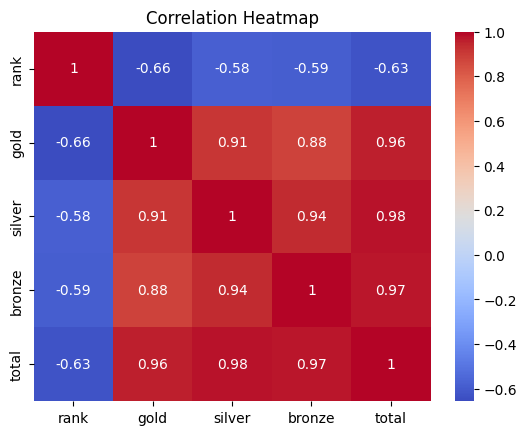

In [17]:
def summary_statistics(df):
    print(df.describe())
    corr = df.corr(numeric_only=True)
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    os.makedirs("output", exist_ok=True)
    plt.savefig("output/correlation_heatmap.png")
    plt.show()

summary_statistics(df)


In [18]:
def run_kmeans(df, n_clusters=3):
    df_numeric = df.select_dtypes(include='number').dropna()
    model = KMeans(n_clusters=n_clusters, random_state=0)
    df['cluster'] = model.fit_predict(df_numeric)
    print("KMeans clustering complete.")
    return df

df = run_kmeans(df)


KMeans clustering complete.


In [ ]:
def run_linear_regression(df, target_col):
    df = df.dropna()
    if target_col not in df.columns:
        print("Target column not found.")
        return

    df_encoded = df.copy()
    for col in df.columns:
        if df[col].dtype == 'object':
            df_encoded[col] = LabelEncoder().fit_transform(df[col].astype(str))

    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)

    print(f"R² Score: {score:.3f}")
    print(f"Coefficients: {model.coef_}")


In [ ]:
def generate_detailed_summary(df, regression_results=None):
    summary = []

    summary.append(f"Data shape: {df.shape[0]} rows, {df.shape[1]} columns.\n")

    summary.append("### Columns and Types:\n")
    summary.append(str(df.dtypes))

    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        summary.append("\n### Missing Values:\n" + str(missing))
    else:
        summary.append("\nNo missing values.\n")

    desc = df.describe().round(2).to_string()
    summary.append("\n### Descriptive Statistics:\n" + desc)

    if regression_results:
        summary.append("\n### Regression Results:\n")
        summary.append(f"Target: {regression_results['target']}")
        summary.append(f"R² Score: {regression_results['r2']:.3f}")
        summary.append("Coefficients:\n" + str(regression_results['coefficients']))

    return "\n".join(summary)


In [21]:
def generate_word_report(summary_text, chart_paths, output_path="output/report.docx"):
    doc = Document()
    doc.add_heading('AI Employee Analysis Report', 0)

    for para in summary_text.split('\n'):
        if para.strip().startswith("###"):
            doc.add_heading(para.strip('#').strip(), level=1)
        else:
            doc.add_paragraph(para)

    doc.add_heading('Charts', level=1)
    for chart in chart_paths:
        if os.path.exists(chart):
            doc.add_picture(chart, width=Inches(5.5))

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    doc.save(output_path)
    print(f"✅ Word report saved at: {output_path}")


In [22]:
def parse_user_input(text):
    text = text.lower()
    if "summary" in text:
        return "summary"
    elif "cluster" in text:
        return "kmeans"
    elif "regression" in text:
        return "regression"
    elif "report" in text:
        return "report"
    elif "exit" in text:
        return "exit"
    else:
        return "unknown"


In [23]:
def run_cli():
    print("🤖 AI Employee CLI is ready.")
    path = input("Enter dataset path (CSV, Excel, JSON): ").strip()
    df = load_any_file(path)
    if df is None:
        print("❌ Could not load file.")
        return
    df = clean_data(df)
    print("✅ Data cleaned.")

    summary_log = []
    charts_log = []
    regression_results = None

    while True:
        cmd = input("\\n💬 Command (summary, cluster, regression, report, exit): ")
        act = parse_user_input(cmd)

        if act == "summary":
            summary_statistics(df)
            charts_log.append("output/correlation_heatmap.png")
            summary_log.append("Generated summary statistics.")

        elif act == "kmeans":
            df = run_kmeans(df)
            summary_log.append("Performed KMeans clustering.")

        elif act == "regression":
            target = input("Target column: ")
            result = run_linear_regression(df, target)
            if result:
                regression_results = result
                summary_log.append(f"Regression on '{target}' with R² = {result['r2']:.3f}")

        elif act == "report":
            detailed = generate_detailed_summary(df, regression_results)
            generate_word_report(detailed, charts_log)
            print("✅ Report created. Exiting.")
            break

        elif act == "exit":
            print("👋 Exiting CLI.")
            break

        else:
            print("❓ Unknown command. Try again.")

🤖 AI Employee CLI is ready.


C:\Users\KIIT\AppData\Local\Temp\ipykernel_16812\3179165516.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


✅ Data cleaned.
            rank       gold     silver     bronze       total
count  91.000000  91.000000  91.000000  91.000000   91.000000
mean   45.307692   3.604396   3.593407   4.219780   11.417582
std    25.652244   6.990278   6.770816   6.558798   19.702829
min     1.000000   0.000000   0.000000   0.000000    1.000000
25%    23.500000   0.000000   0.000000   1.000000    2.000000
50%    44.000000   1.000000   1.000000   2.000000    5.000000
75%    68.000000   3.000000   3.000000   5.000000    9.000000
max    84.000000  40.000000  44.000000  42.000000  126.000000


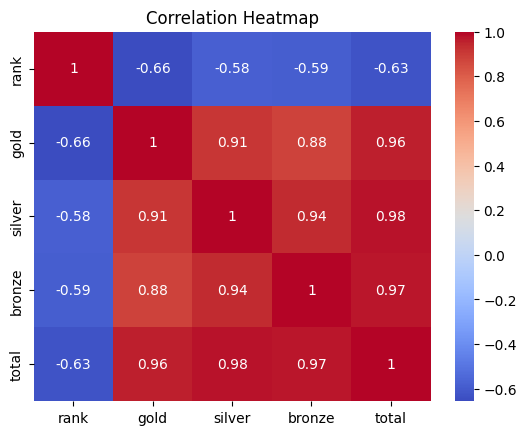

KMeans clustering complete.
Target column not found.
✅ Word report saved at: output/report.docx
✅ Report created. Exiting.


In [24]:
run_cli()